# SAT 5141 Research Project

### 🔍Explainable AI for Real-Time Clinical Decision Support in Predicting 30-Day Readmission for Diabetic Patients.

### Problem Overview
This project explores machine learning–based prediction of hospital readmissions using a real-world, multi-class clinical dataset.
The goal is not only to build predictive models, but to understand why they make certain predictions through explainable AI (XAI), ensuring usability and applicability in real-world clinical decision support systems (CDSS).

### Data Understanding


In [3]:
# import needed libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing


In [4]:
# 1. Load Dataset
# -----------------------------
def load_data(filepath):
    """Load the UCI diabetes readmission dataset."""
    df = pd.read_csv(filepath)
    print(f"✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

df = load_data('diabetic_data.csv')

✅ Dataset loaded: 101766 rows, 50 columns


#### drop irrelevant columns, handle missing values

In [5]:
# 2. Clean Data
# -----------------------------
def clean_data(df):
    """Clean dataset by handling missing and irrelevant data."""
    # Drop non-predictive identifiers
    df = df.drop(['encounter_id'], axis=1, errors='ignore')

    # Replace '?' with NaN
    df.replace('?', np.nan, inplace=True)

    # Drop columns with >40% missing values
    missing_ratio = df.isnull().mean()
    cols_to_drop = missing_ratio[missing_ratio > 0.4].index
    df.drop(cols_to_drop, axis=1, inplace=True)

    # Fill missing values in categorical columns with mode
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

    print(f"🧹 Data cleaned: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

df = clean_data(df)

🧹 Data cleaned: 101766 rows, 45 columns


### EDA (exploratory data analysis)
We will explore distributions and basic statistics. Univariate and Bivariate analysis and visualization will be done in this section.

In [44]:
def univariate_analysis(df):
    """function to do basic univariate analysis"""
    
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    print("🔹 NUMERIC COLUMN SUMMARY")
    display(df[numeric_cols].describe())

    print("\n🔹 CATEGORICAL COLUMN SUMMARY")
    display(df[cat_cols].describe())

    # Histograms for numeric columns
    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

    # Bar plots for categorical variables
    for col in cat_cols:
        plt.figure(figsize=(6,4))
        df[col].value_counts().plot(kind='bar')
        plt.title(f"Frequency of {col}")
        plt.show()

In [6]:
# bivariate analysis

# Numeric features vs target.
def bivariate_numeric_vs_target(df, target='readmitted'):
    """Function that plots numeric features against target"""
    
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=target, y=col, data=df)
        plt.title(f"{col} by {target}")
        plt.show()


In [7]:
# 2. Categorical vs Target
def bivariate_categorical_vs_target(df, target='readmitted'):
    """Function that plots categorical features against target"""
    
    cat_cols = df.select_dtypes(include=['object']).columns
    
    for col in cat_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, hue=target, data=df)
        plt.title(f"{col} vs {target}")
        plt.xticks(rotation=45)
        plt.show()


In [8]:
# correlation matrix
def correlation_heatmap(df):
    """Function to plot correlation matrix"""

    numeric_df = df.select_dtypes(include=['int64', 'float64'])

    plt.figure(figsize=(14,10))
    sns.heatmap(numeric_df.corr(), annot=False, cmap="viridis")
    plt.title("Correlation Matrix (Numeric Features Only)")
    plt.show()



===== UNIVARIATE ANALYSIS =====
🔹 NUMERIC COLUMN SUMMARY


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000



🔹 CATEGORICAL COLUMN SUMMARY


,race,gender,age,payer_code,diag_1,diag_2,diag_3,metformin,repaglinide,nateglinide,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,17,716,748,789,4,4,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),MC,428,276,250,No,No,No,...,No,No,No,No,No,No,No,No,Yes,NO
freq,78372,54708,26068,72695,6883,7110,12978,81778,100227,101063,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


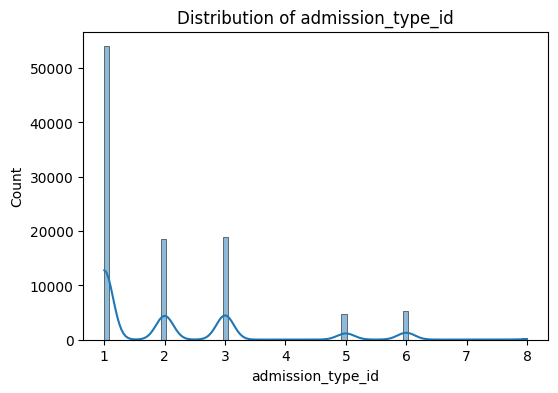

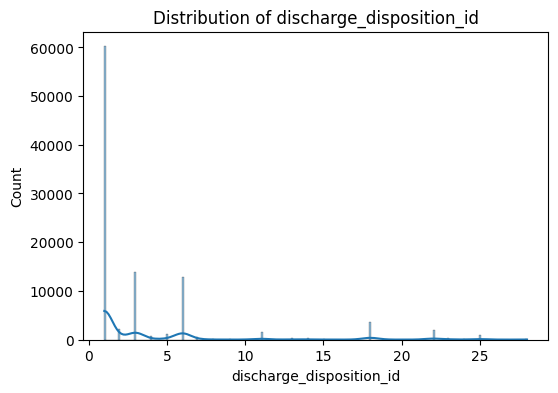

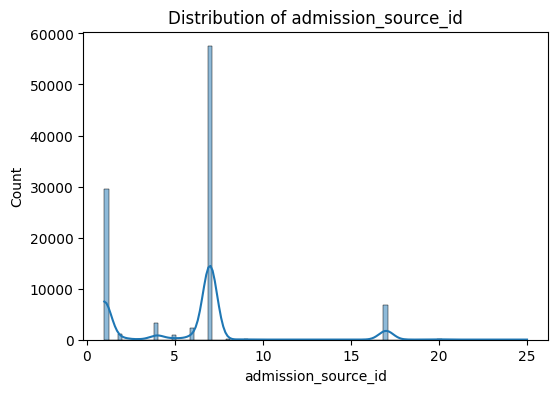

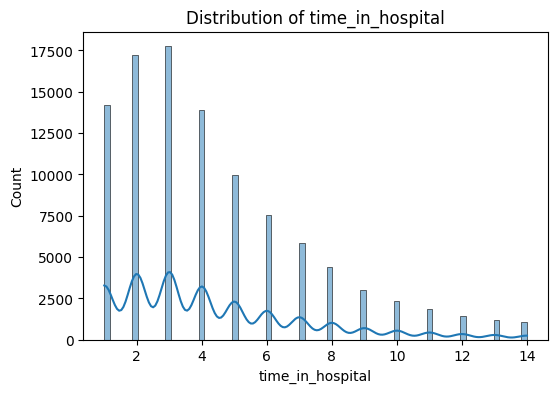

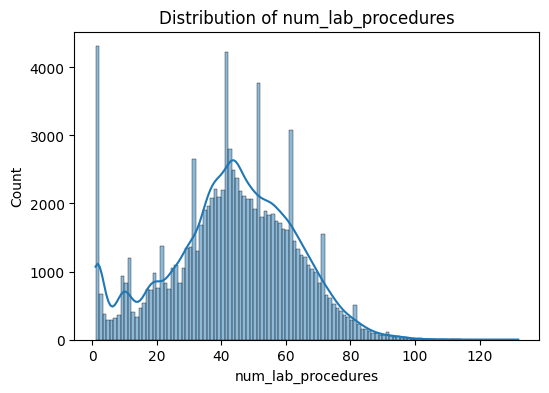

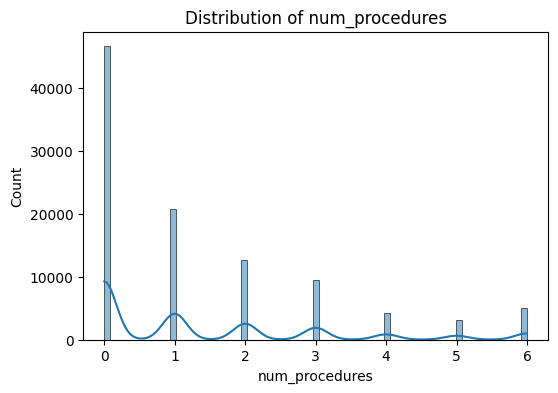

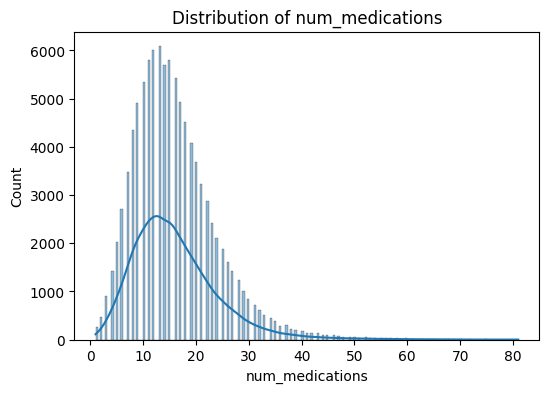

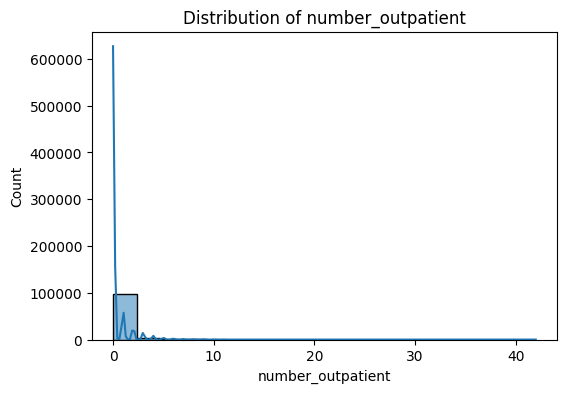

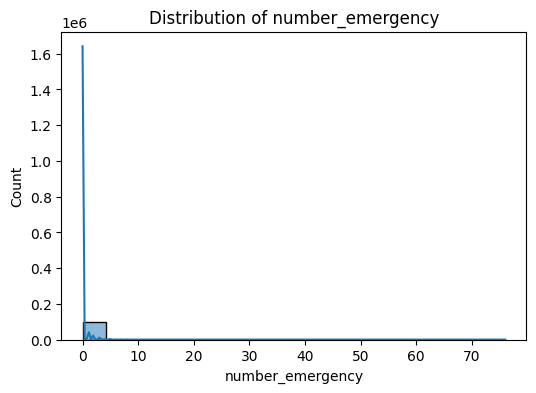

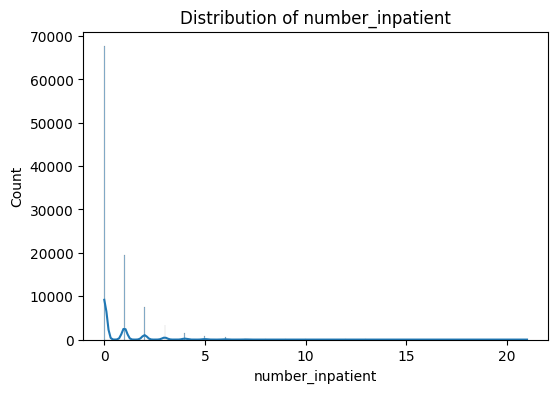

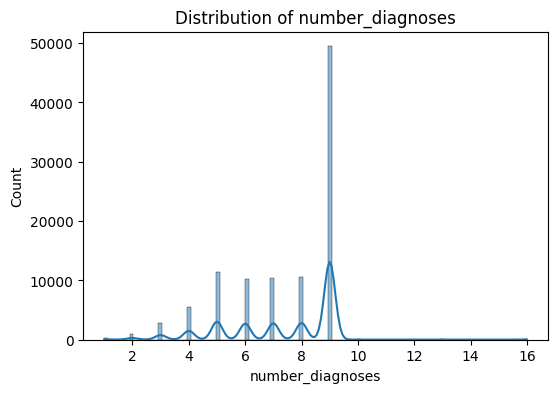

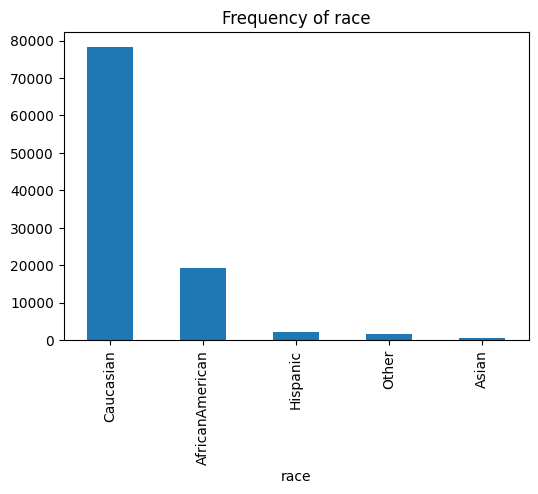

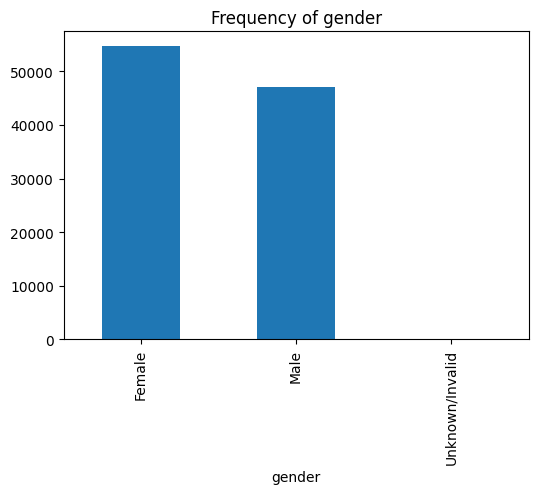

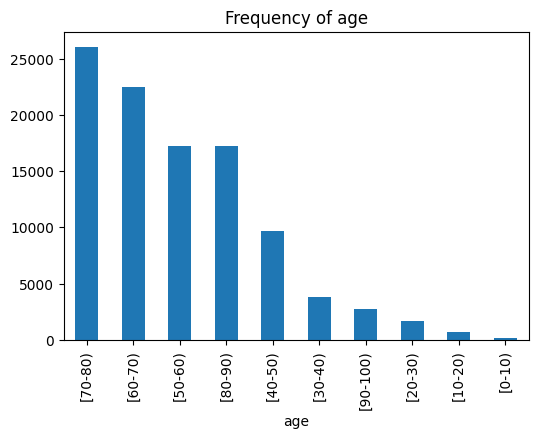

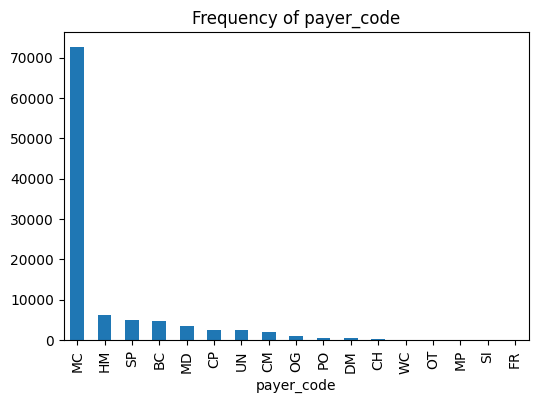

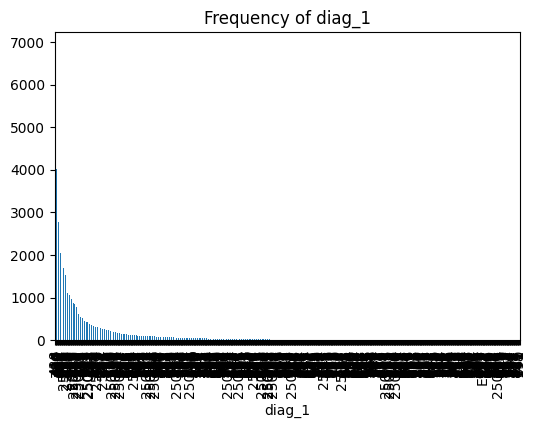

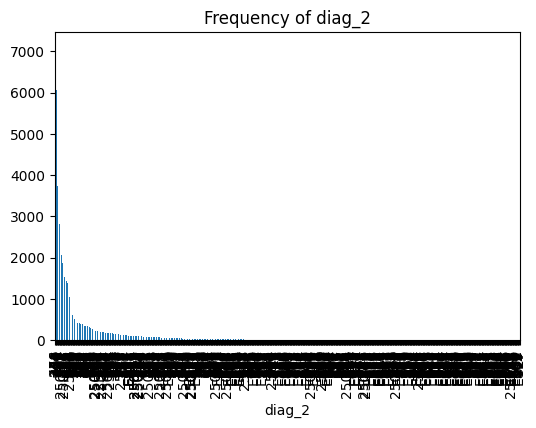

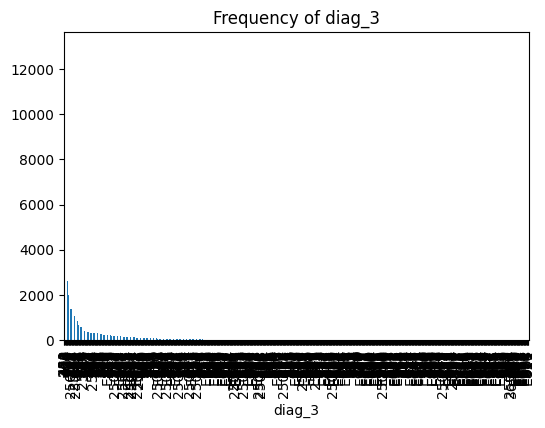

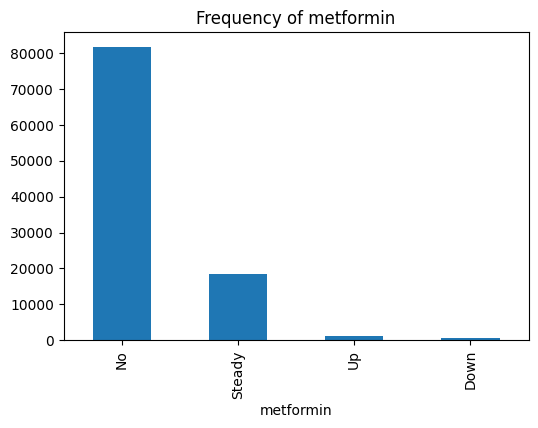

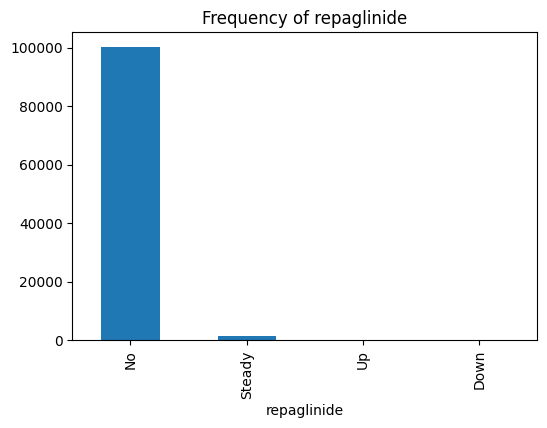

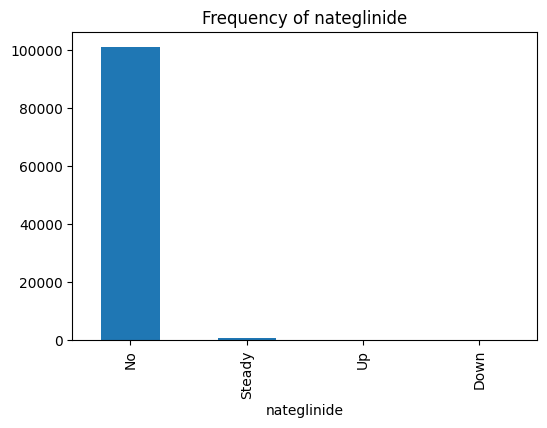

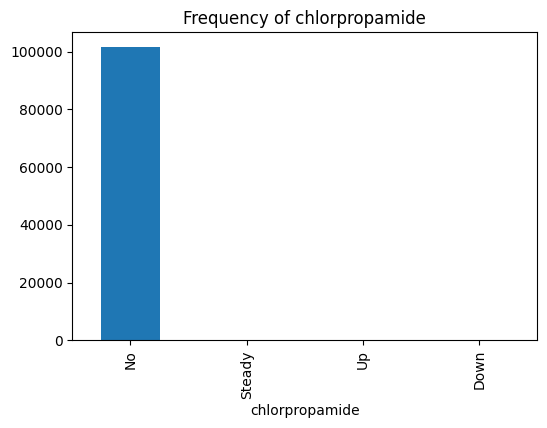

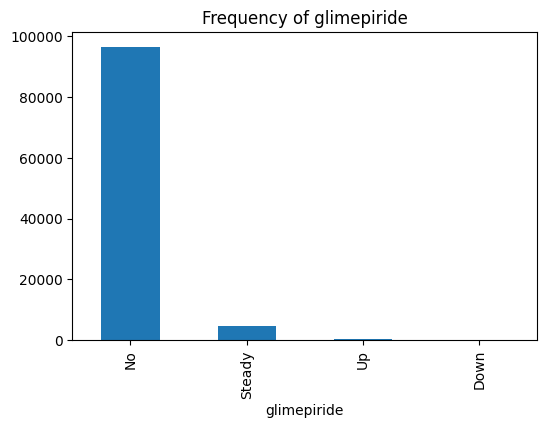

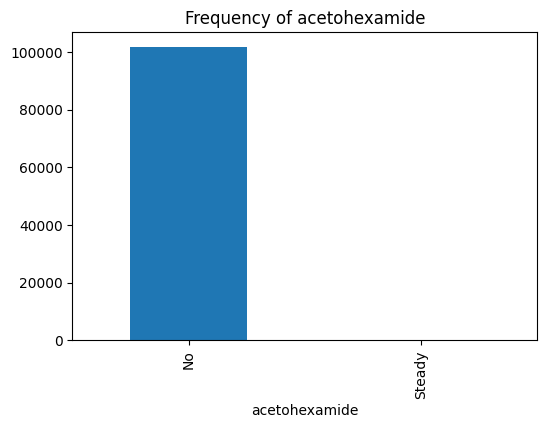

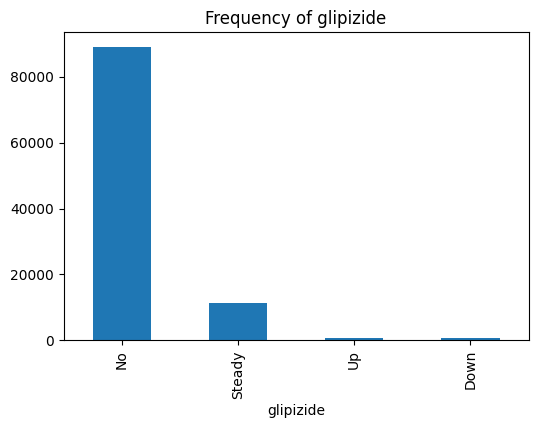

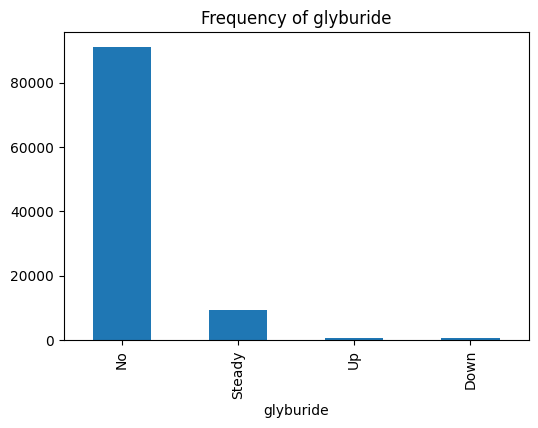

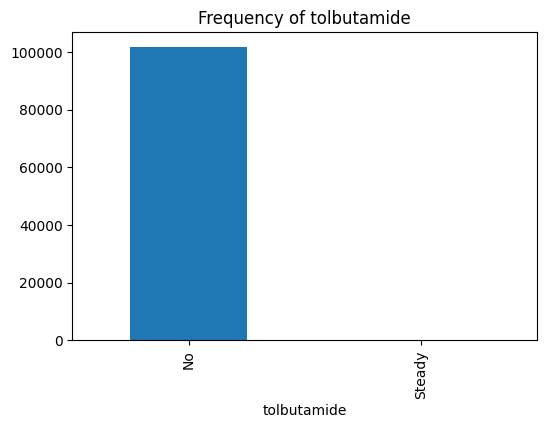

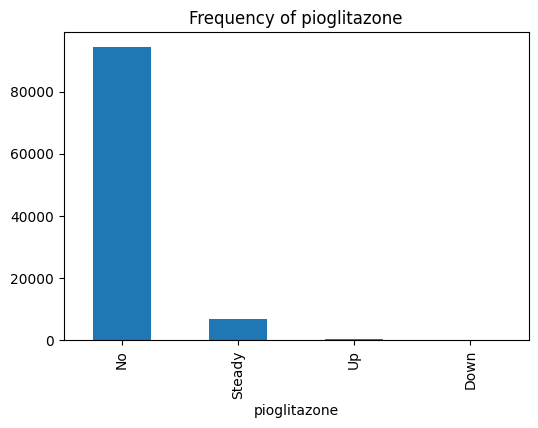

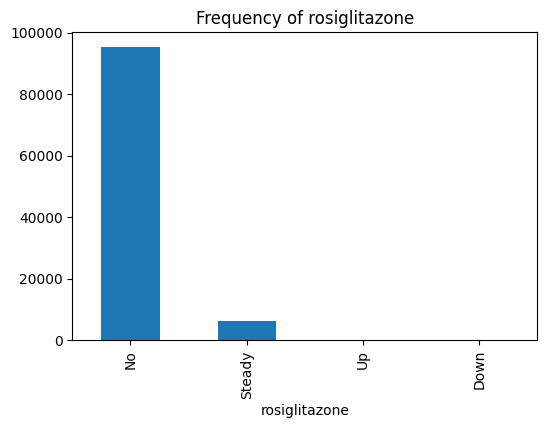

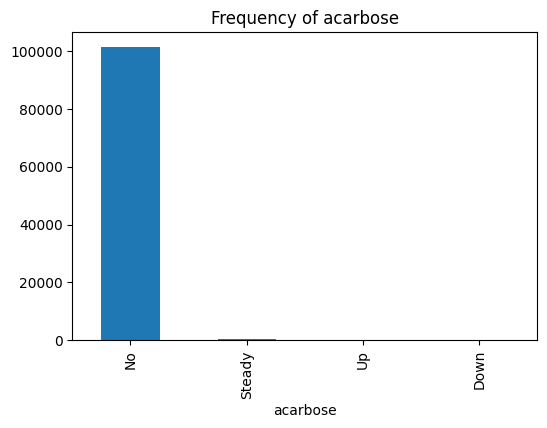

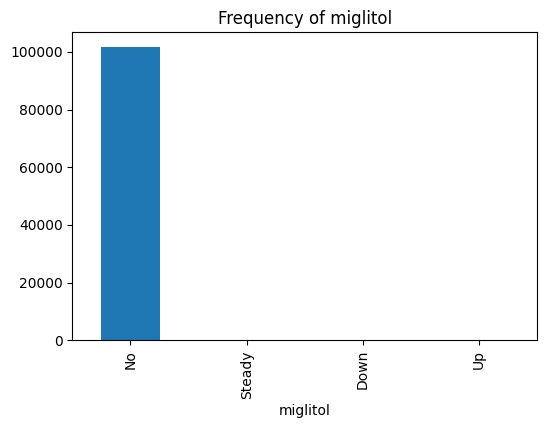

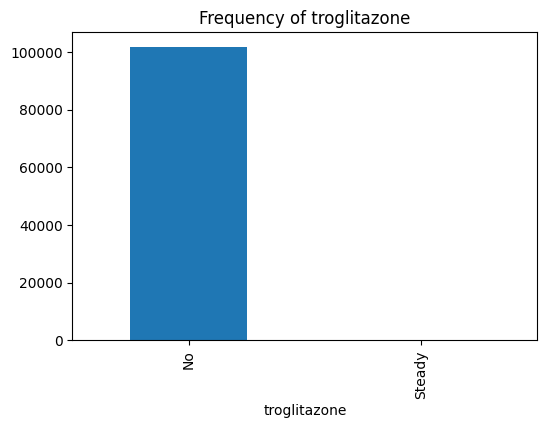

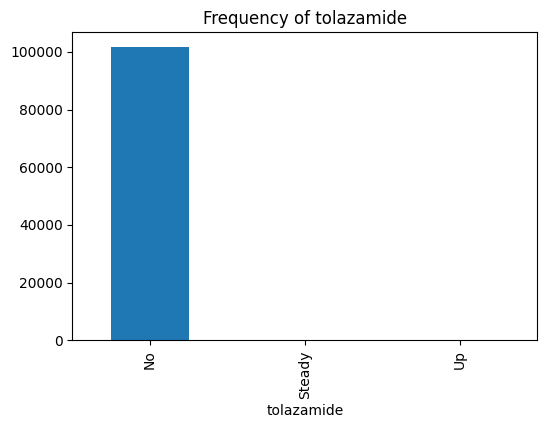

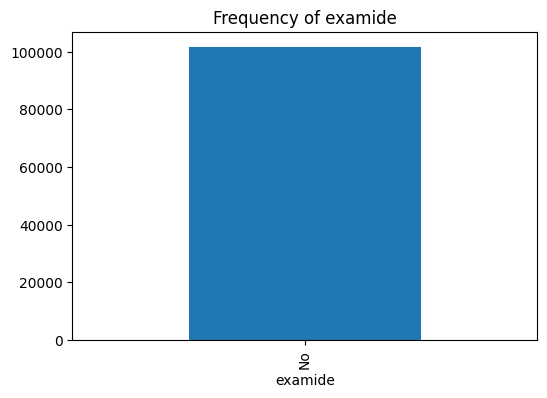

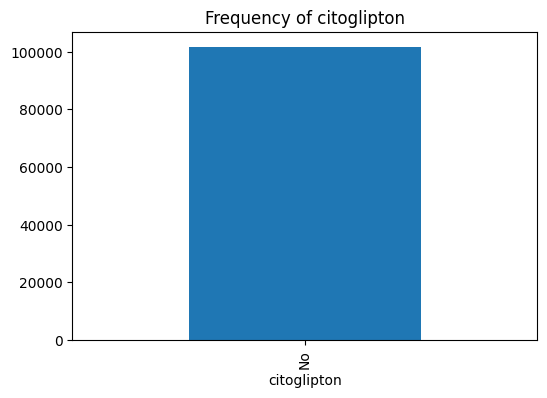

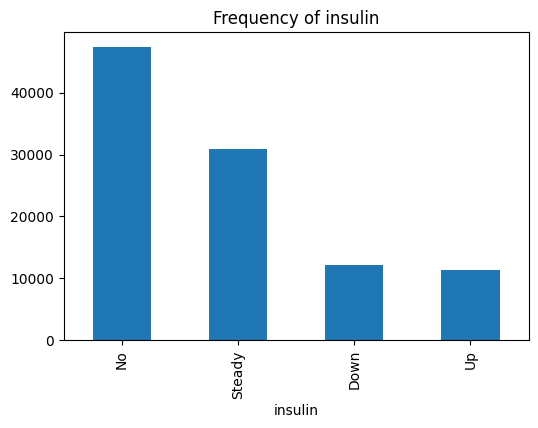

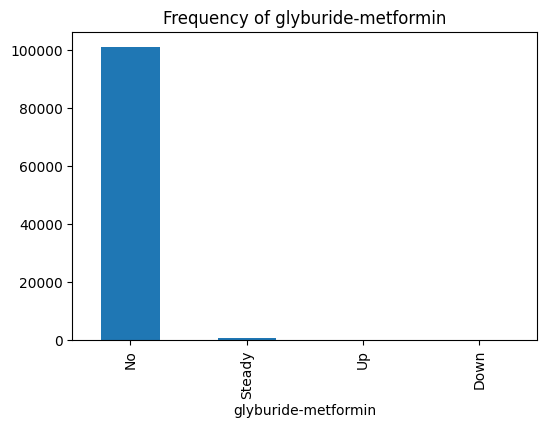

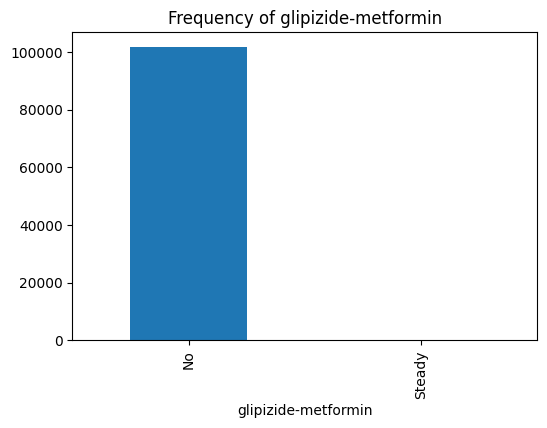

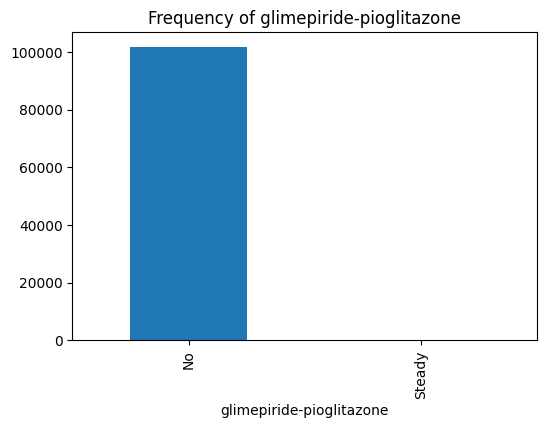

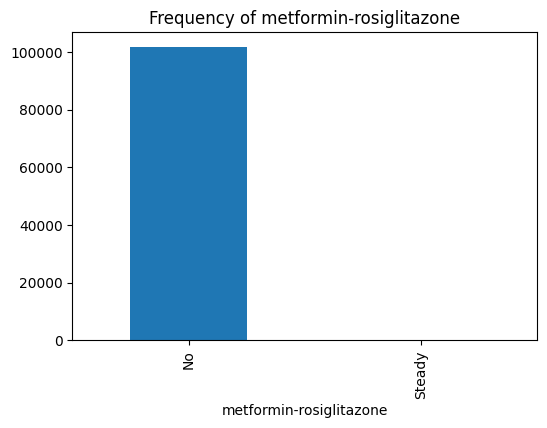

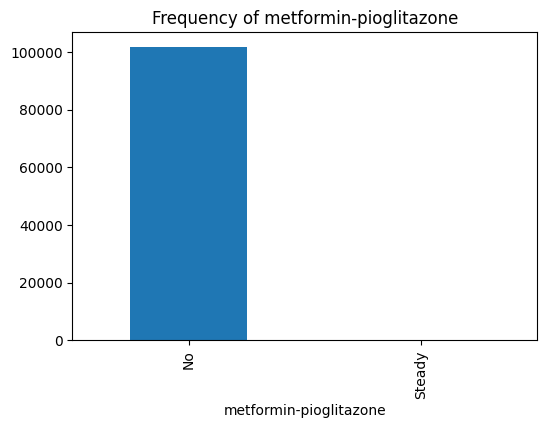

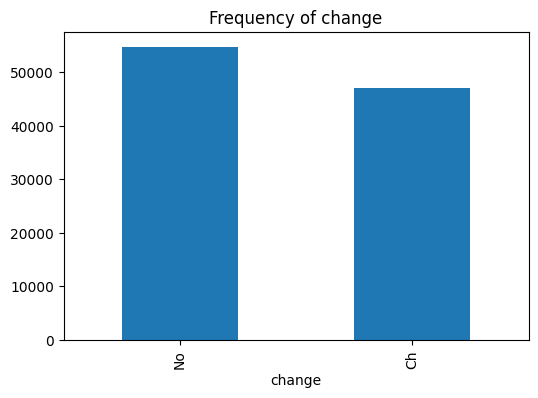

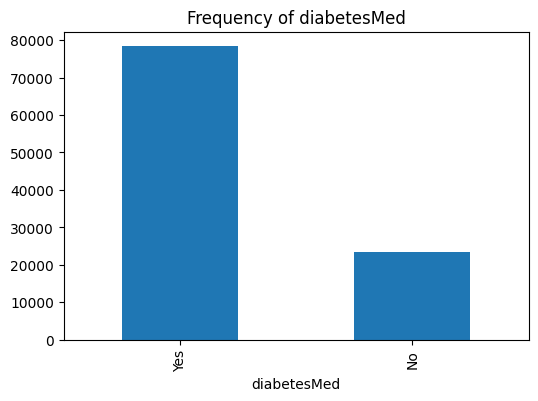

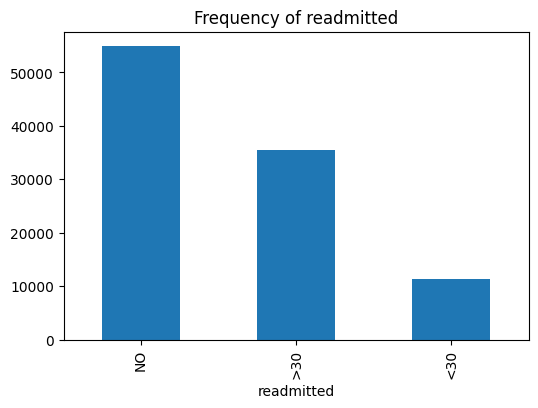

In [ ]:
# Univariate Function call
print("===== UNIVARIATE ANALYSIS =====")
univariate_analysis(df)


===== BIVARIATE: NUMERIC vs TARGET =====


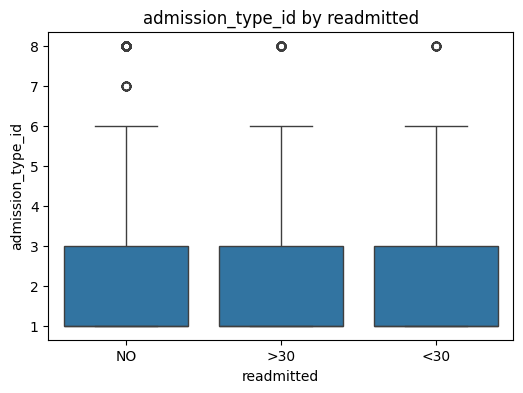

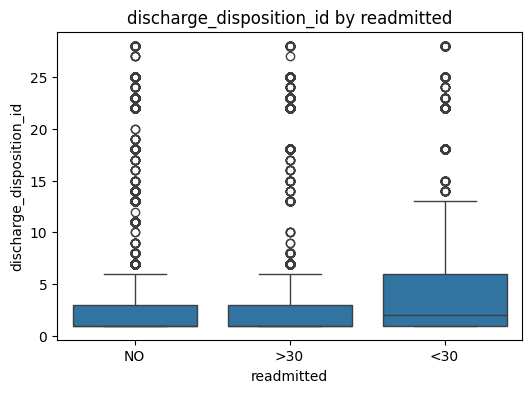

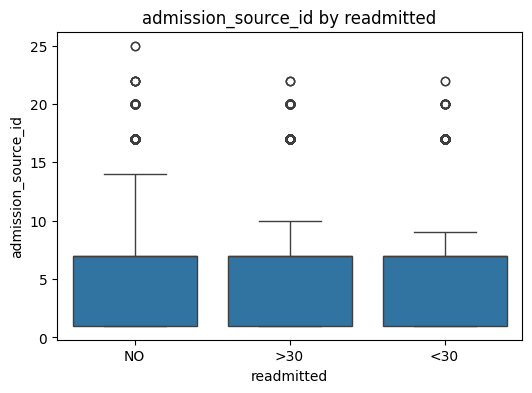

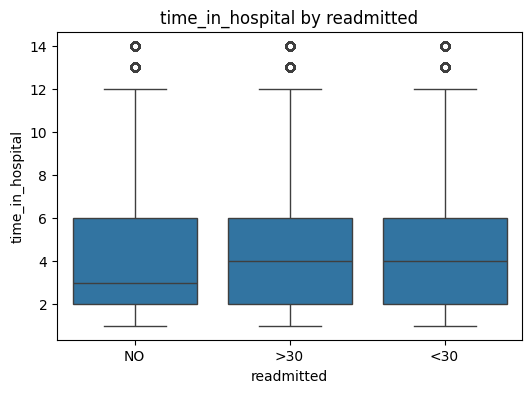

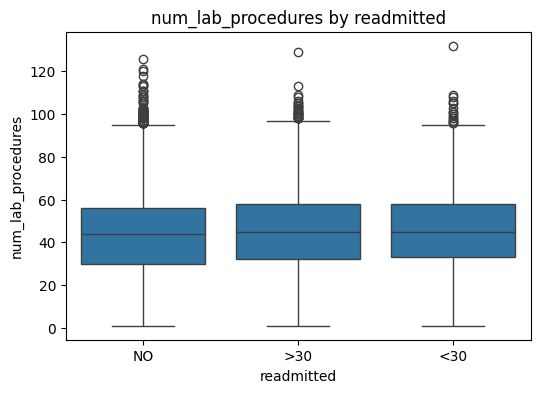

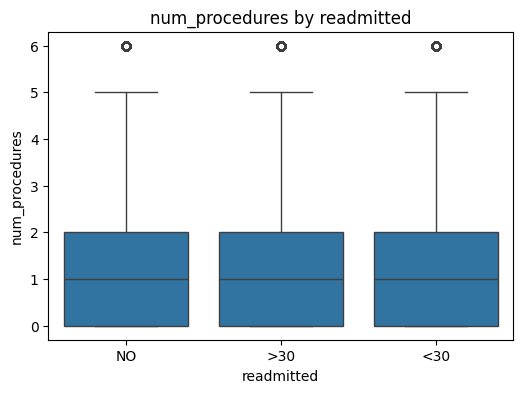

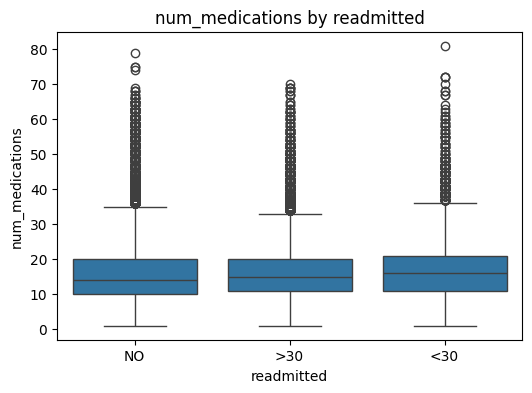

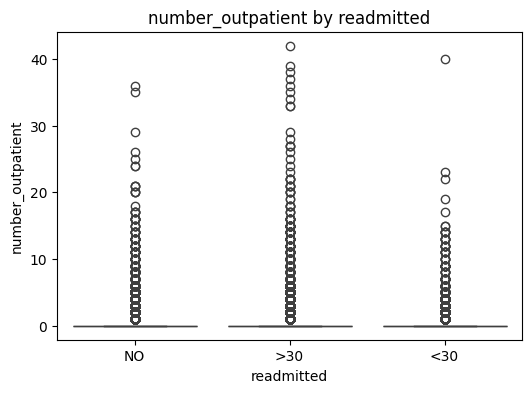

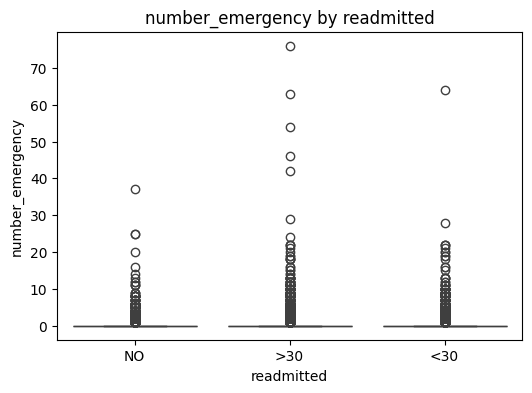

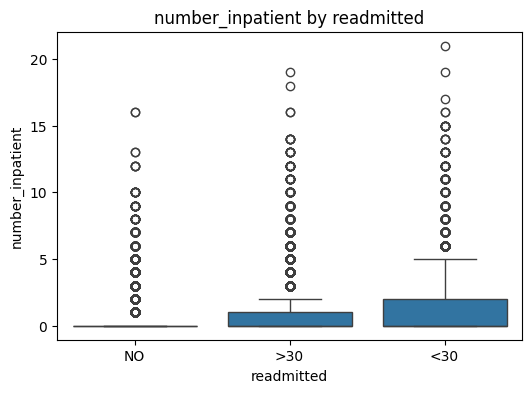

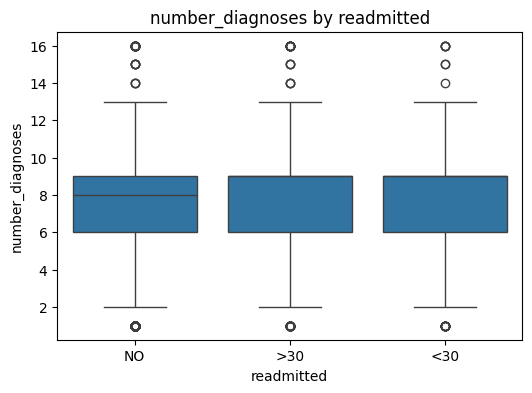

In [49]:
print("\n===== BIVARIATE: NUMERIC vs TARGET =====")
bivariate_numeric_vs_target(df)


===== BIVARIATE: CATEGORICAL vs TARGET =====


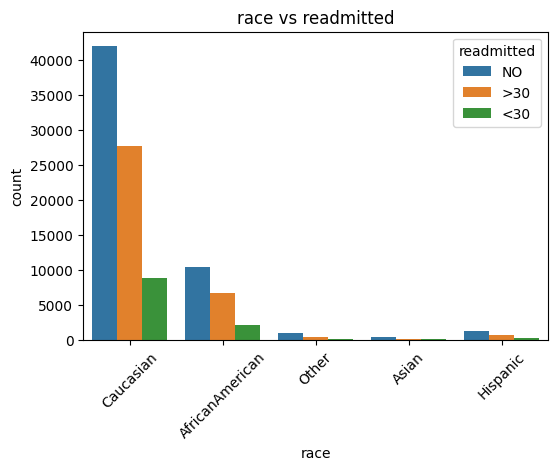

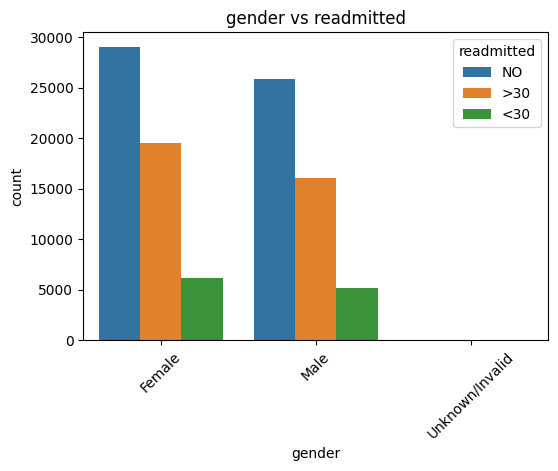

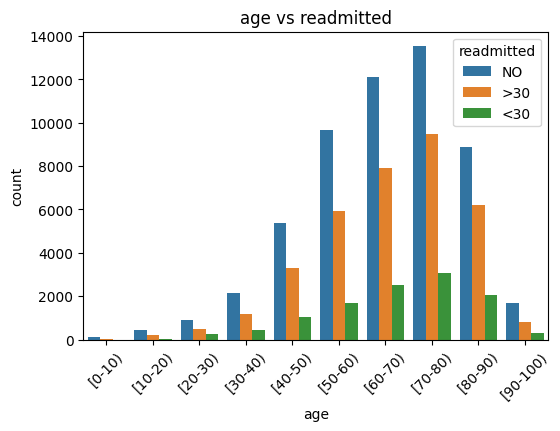

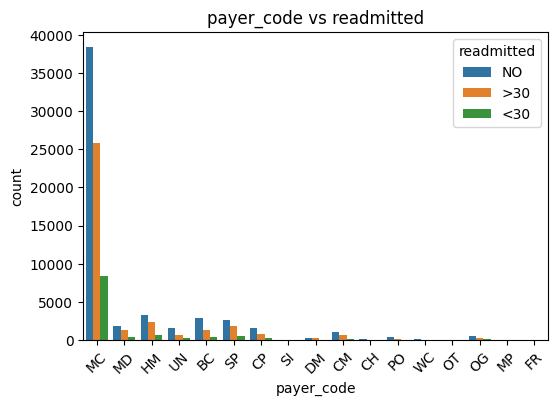

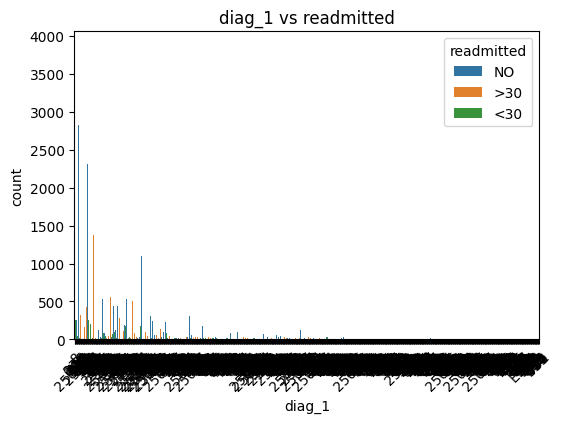

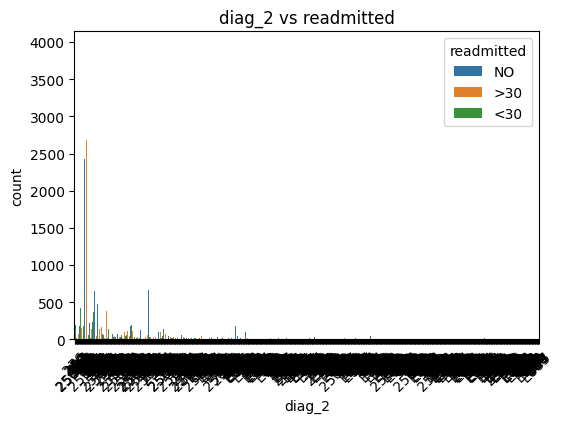

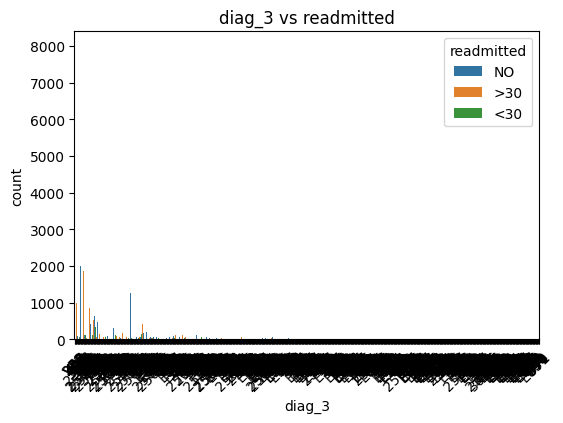

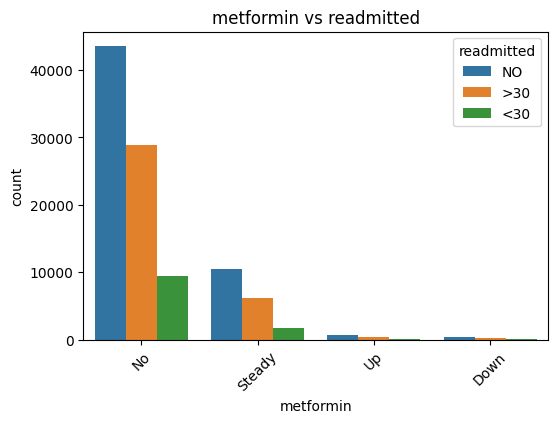

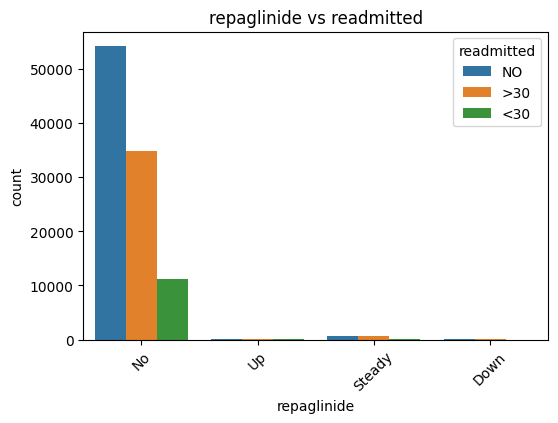

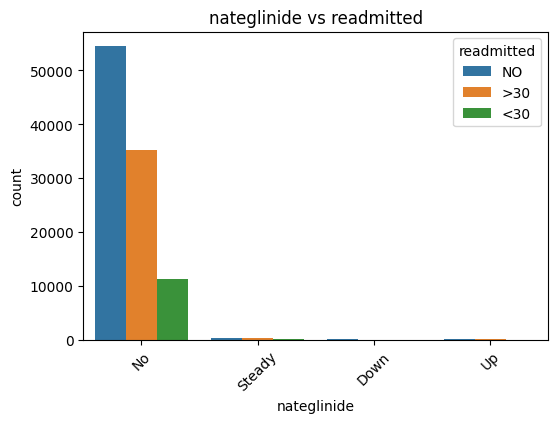

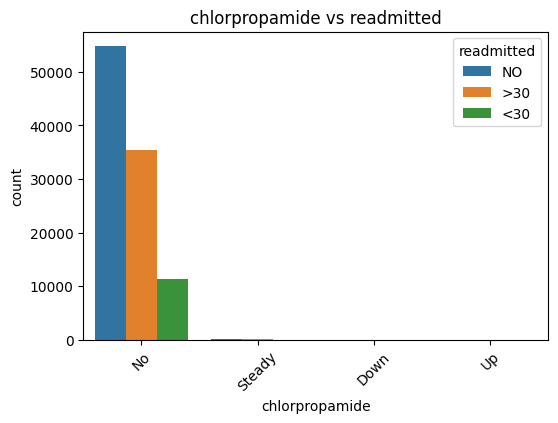

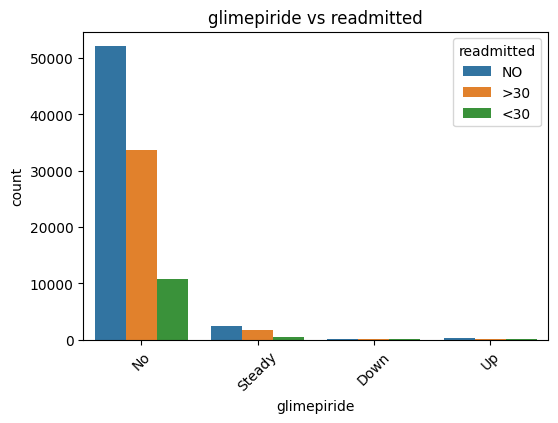

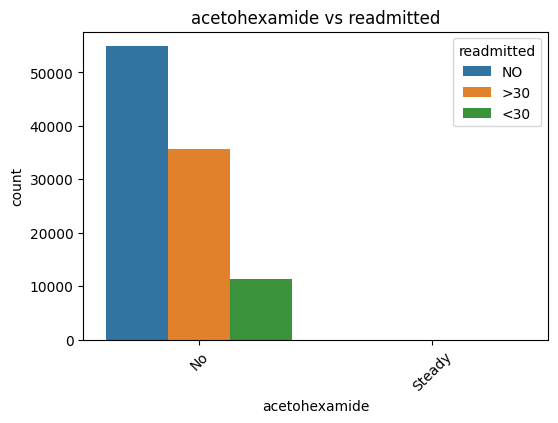

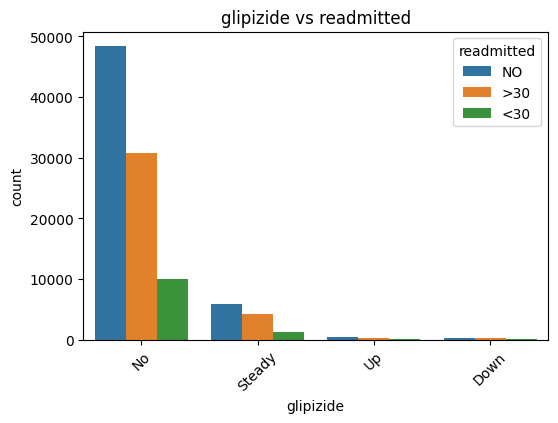

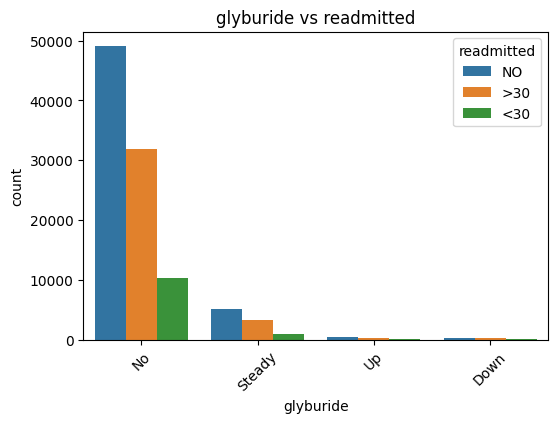

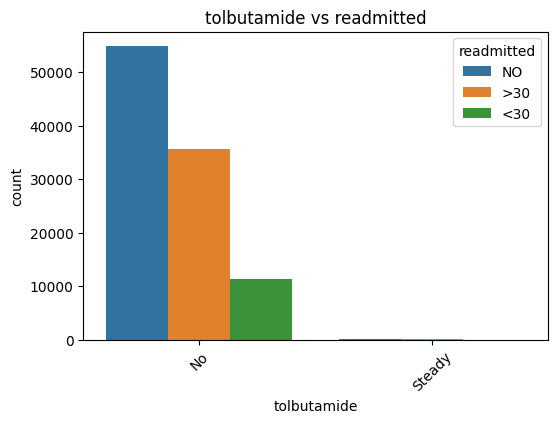

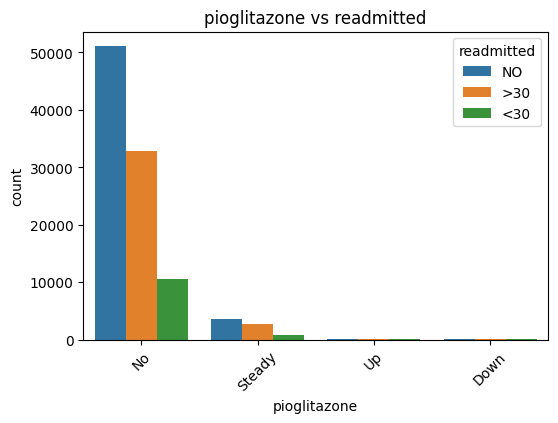

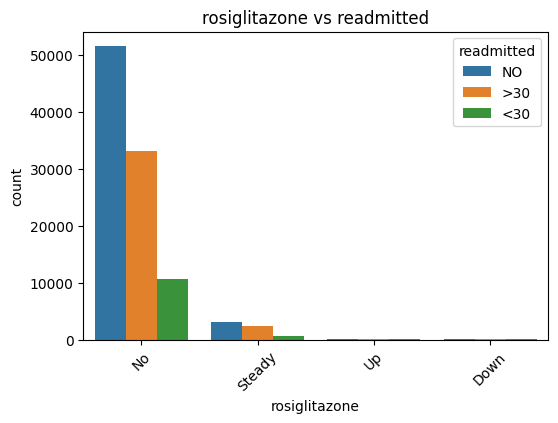

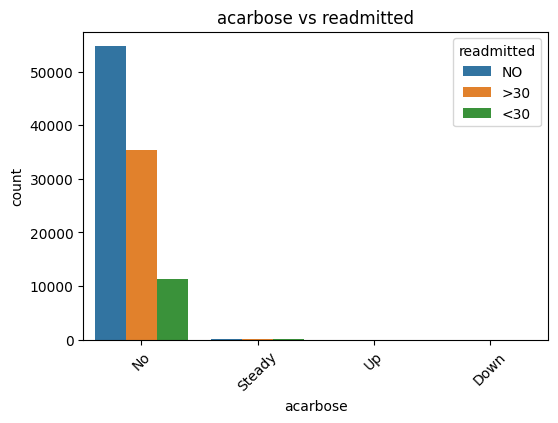

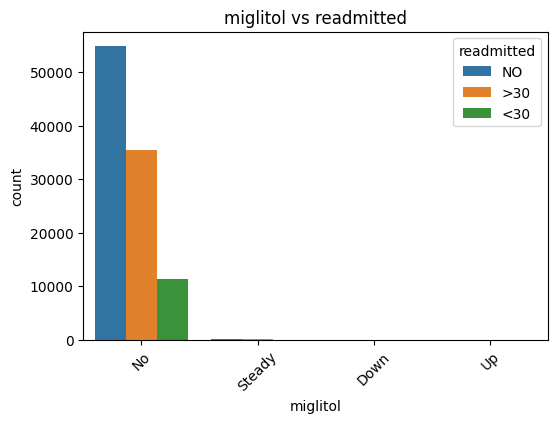

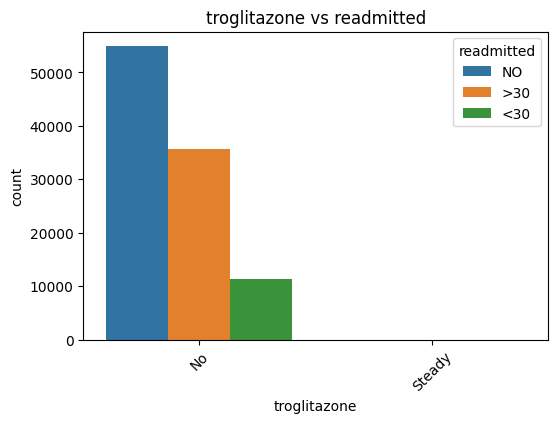

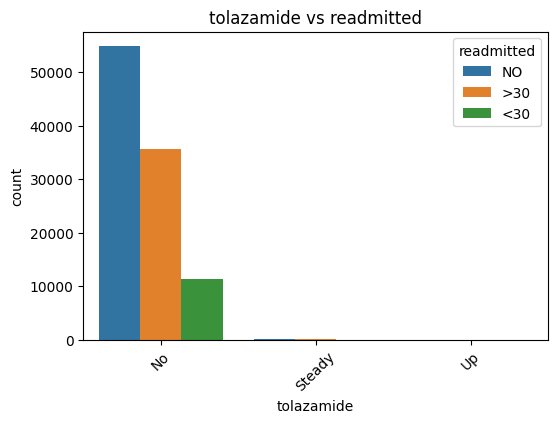

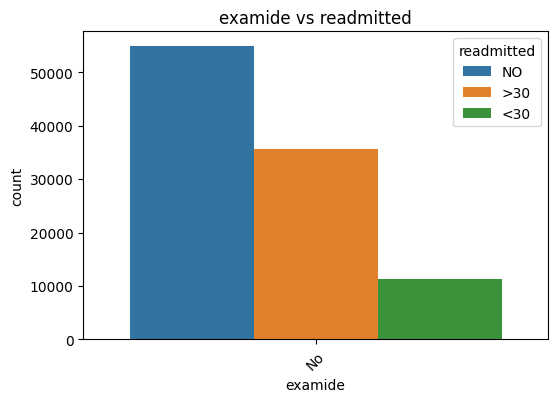

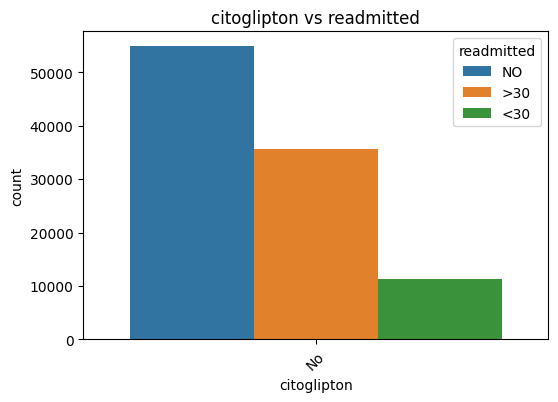

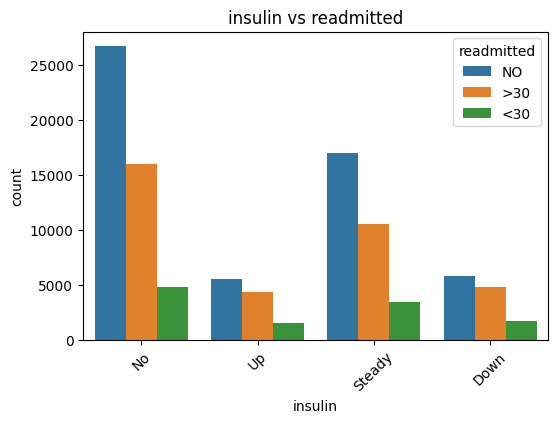

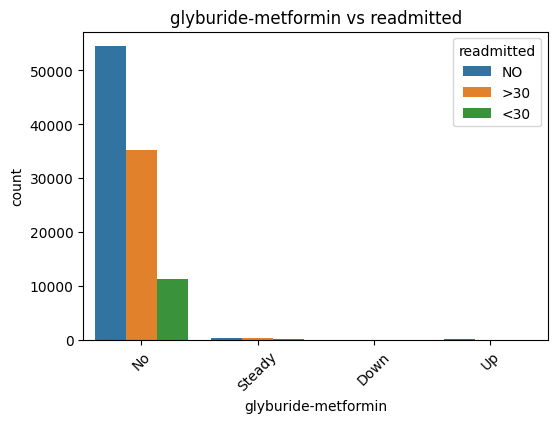

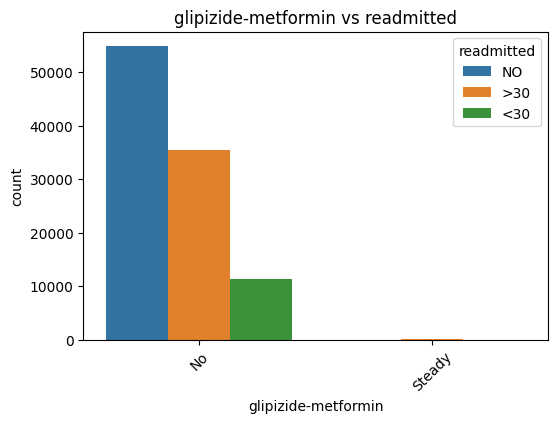

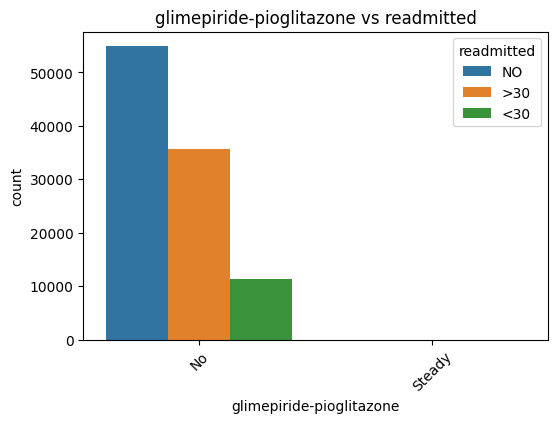

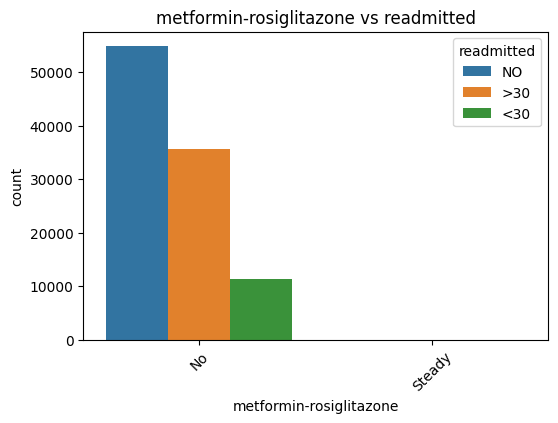

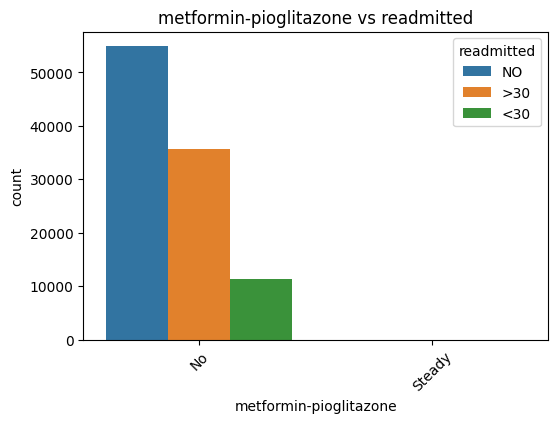

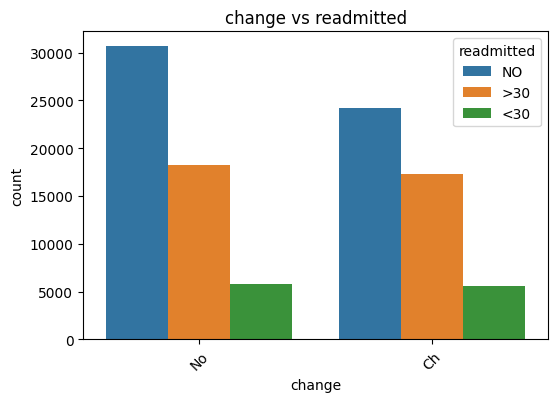

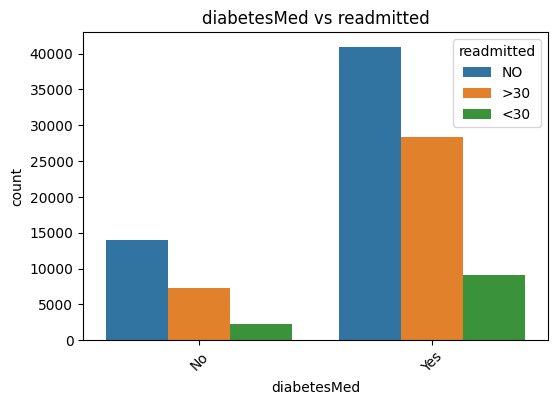

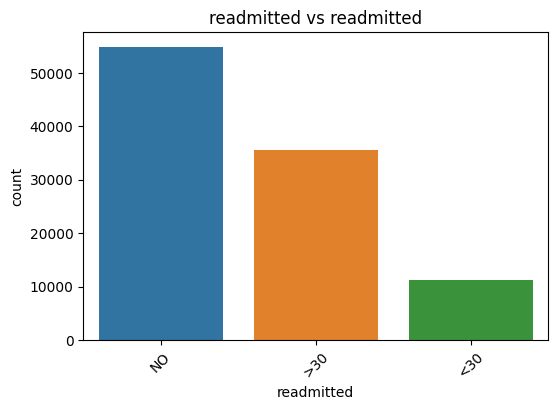

In [ ]:
# bivariate function call
print("\n===== BIVARIATE: CATEGORICAL vs TARGET =====")
bivariate_categorical_vs_target(df)

- Some of the plots have the xaxis label squeezed. I tried spacing them but to no avail.


===== CORRELATION HEATMAP =====


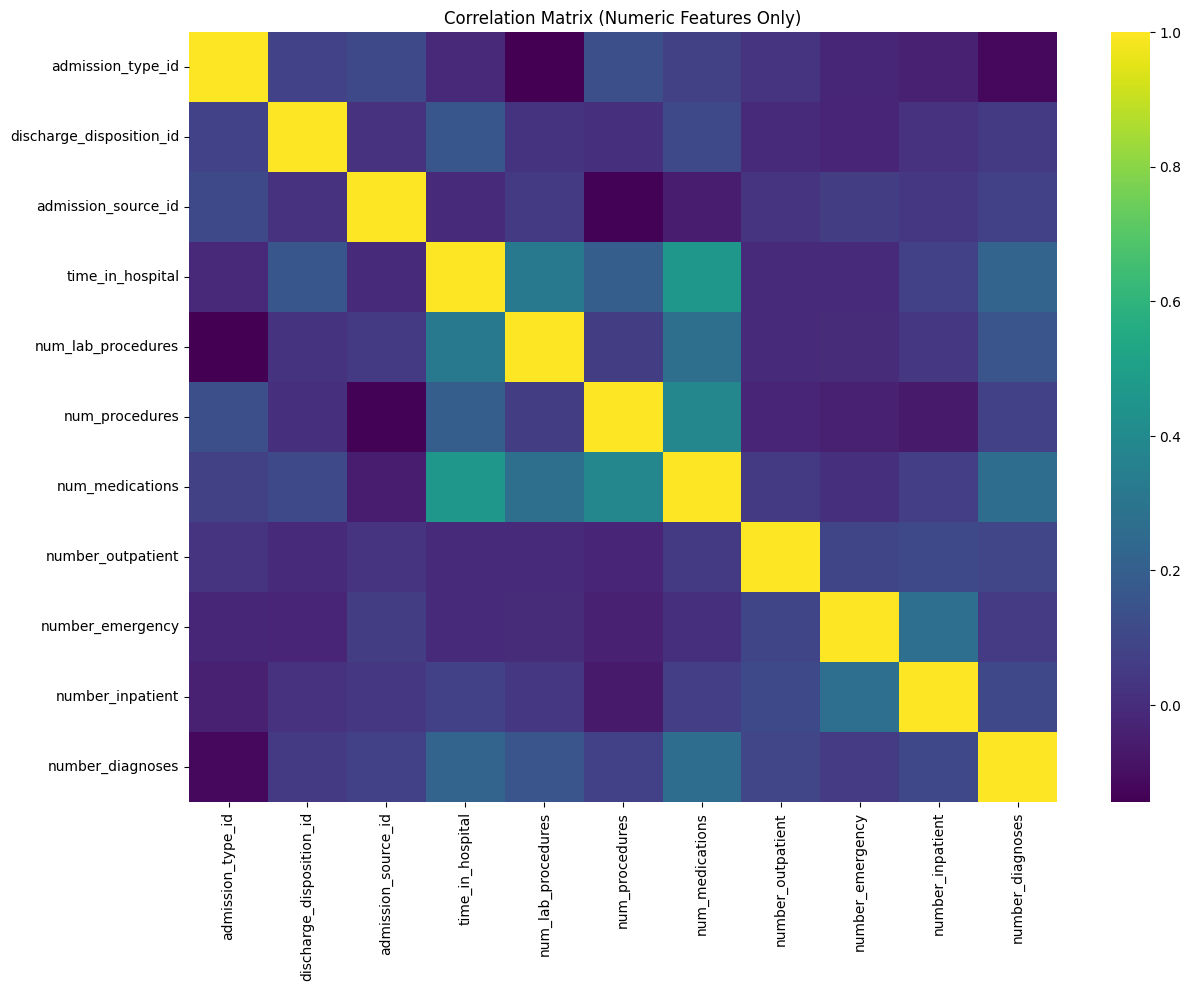

In [50]:
print("\n===== CORRELATION HEATMAP =====")
correlation_heatmap(df)

### Correlation Analysis of Numeric Features

In general, most features show weak correlations with one another, indicating that they contribute relatively independent information when modeling patient outcomes.

> A few notable relationships do stand out:

- Time in hospital shows a moderate positive correlation with number of medications and number of lab procedures, which makes clinical sense—longer stays typically require more tests and treatments.

- Number of inpatient visits is moderately correlated with time in hospital and number of diagnoses. Patients with more complex or severe conditions are more likely to be readmitted and require longer stays.

- Number of emergency visits shares some weak-to-moderate positive correlations with other utilization measures, suggesting that frequent emergency use may be part of a broader pattern of high healthcare utilization.

- Administrative identifiers such as admission type, discharge disposition, and admission source show low correlations with most medical usage features, implying they capture a different dimension of information.

Importantly, the absence of strong multicollinearity (correlation values close to ±1) indicates that these variables can be jointly included in predictive modeling without causing significant redundancy or distortion of the model coefficients. Overall, the matrix suggests a diverse set of predictors that may each add value when analyzing or predicting clinical outcomes.

#### categorical column encoding
- transforming to numeric representatives.

In [9]:
def encode_categorical(df):
    """Convert categorical variables into numeric format."""
    categorical_cols = df.select_dtypes(include=['object']).columns

    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    print(f"🔠 Encoded {len(categorical_cols)} categorical columns.")
    return df

df = encode_categorical(df)

🔠 Encoded 33 categorical columns.


#### Outliers
- Dealing with extreme values.

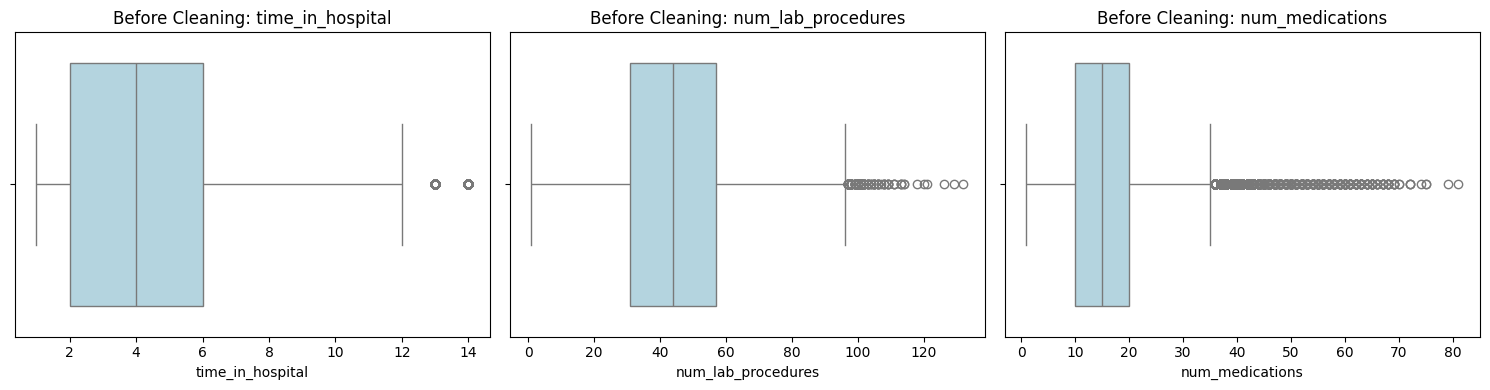

In [10]:
# Visualize Outliers
# -------------------------------
def visualize_outliers(df, cols):
    """function to visualize outliers given columns"""

    plt.figure(figsize=(15, 4))
    for i, col in enumerate(cols):
        plt.subplot(1, len(cols), i + 1)
        sns.boxplot(x=df[col], color='lightblue')
        plt.title(f"Before Cleaning: {col}")
    plt.tight_layout()
    plt.show()

numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_medications']
visualize_outliers(df, numeric_cols)

In [ ]:
# Remove Outliers
# -------------------------------
def remove_outliers(df, cols):
    """function to remove outliers"""

    df_clean = df.copy()
    for col in cols:
        Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

df_clean = remove_outliers(df, numeric_cols)

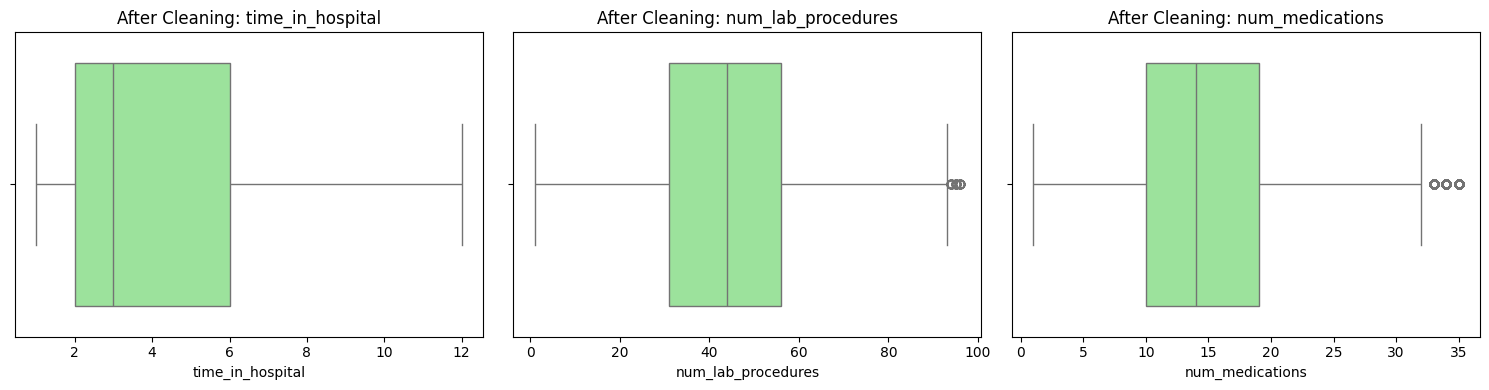

In [ ]:
# Visualize After Cleaning
# -------------------------------
def visualize_after_cleaning(df, cols):
    """function to visualize after cleaning"""

    plt.figure(figsize=(15, 4))
    for i, col in enumerate(cols):
        plt.subplot(1, len(cols), i + 1)
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f"After Cleaning: {col}")
    plt.tight_layout()
    plt.show()
    
visualize_after_cleaning(df_clean, numeric_cols)

We specifically targeted:

- <b>time_in_hospital</b>
- <b>num_lab_procedures</b>
- <b>num_medications</b>

These features are continuous clinical variables that heavily influence readmission risk, but in raw data they often contain extreme, unrealistic values due to data entry errors or rare medical anomalies.

👉 Rationale:

- time_in_hospital: Typically 1–14 days for diabetic patients. Values beyond 30+ are likely outliers or data errors.
- num_lab_procedures: Most patients have 20–100 lab tests per admission; some records show more than 300, which skews the distribution.
- num_medications: Generally under 50, but some entries exceed 80–100 (possible duplicates or mis-entries).
- Removing these prevents model bias — otherwise, the model may overfit to a few rare, extreme cases that don’t generalize.

## Feature engineering
- Creating new features that may help in modeling.
- We will group the ages into discrete bins so as to simplify analysis and make results easier to communicate to stakeholders. 

In [13]:
# Feature Engineering
# -------------------------------
def feature_engineering(df):
    df = df.copy()

    # Age grouping
    if 'age' in df.columns:
        df['age_group'] = pd.cut(df['age'],
                                 bins=[0, 30, 50, 70, 90, 120],
                                 labels=['<30', '30-50', '50-70', '70-90', '90+'])

    # Comorbidity score: count of diagnosed conditions (based on ICD-like columns)
    comorbidity_cols = [c for c in df.columns if 'diag' in c or 'diagnosis' in c]
    df['comorbidity_score'] = df[comorbidity_cols].notna().sum(axis=1)

    # Medication counts (assuming columns with medication info)
    med_cols = [c for c in df.columns if 'med' in c or 'drug' in c]
    if med_cols:
        df['total_meds'] = df[med_cols].notna().sum(axis=1)
    
    # Binary feature: had previous readmission
    if 'readmitted' in df.columns:
        df['prev_readmit'] = df.groupby('patient_nbr')['readmitted'].shift(1).fillna(0)

   
    
    return df

df_features = feature_engineering(df_clean) # function call.

In [14]:
# displaying new features.
df_features.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'age_group', 'comorbidity_score',
       'total_meds', 'prev_readmit'],
      dtype='object')

In [15]:
# function to convert categorical 
def encode_categoricals(df, categorical_cols):
    encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = encoder.fit_transform(df[col].astype(str))
    return df

In [16]:
# Encode new categorical feature
if 'age_group' in df_features.columns:
    df_features = encode_categoricals(df_features, ['age_group'])

In [17]:
df_features['age_group'].info() # inspecting age_group

<class 'pandas.core.series.Series'>
Index: 97197 entries, 0 to 101765
Series name: age_group
Non-Null Count  Dtype
--------------  -----
97197 non-null  int64
dtypes: int64(1)
memory usage: 1.5 MB


### Patient-Level splitting
- Meant to prevent leakage.

In [ ]:
# 5. Patient-Level Split function
# -------------------------------
def patient_level_split(df, patient_id_col, test_size=0.2, random_state=42):
    """function to carry out patient level splitting"""
    
    splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=random_state)
    for train_idx, test_idx in splitter.split(df, groups=df[patient_id_col]):
        train = df.iloc[train_idx]
        test = df.iloc[test_idx]
    return train, test


patient_id_col = 'patient_nbr'
train_df, test_df = patient_level_split(df_features, patient_id_col)

#### Why GroupShuffleSplit instead of Train_Test_Split, (GroupShuffleSplit, n.d.)

- In this clinical readmission prediction problem, each patient (patient_nbr) can have multiple hospital visits (records).
- If we use a normal train_test_split, it will randomly split individual records i.e. Some visits from the same patient could end up in both training and testing sets. This causes data leakage — the model indirectly learns patient-specific patterns (like comorbidities, demographics, or care patterns) it will also see during testing.
- As a result, evaluation metrics (AUC, F1, etc.) will look artificially high, but won’t generalize to new patients in real-world settings.

<b>How GroupShuffleSplit Solves This</b>

GroupShuffleSplit ensures:

- All records belonging to the same patient (group) go into only one set i.e. either training or testing.
- This mimics real-world deployment: model sees new patients during testing, not ones it already “knows”.

## Modeling

In [19]:
# dropping patient_nbr to prevent leakage.
train_df = train_df.drop('patient_nbr', axis=1) 
test_df = test_df.drop('patient_nbr', axis=1)


In [20]:
# 2. Train–test separation
X_train = train_df.drop(columns=['readmitted'])
y_train = train_df['readmitted'] # target

X_test = test_df.drop(columns=['readmitted'])
y_test = test_df['readmitted'] # target

### SMOTE (GeeksforGeeks, 2025)

In [21]:
### applying SMOTE to training set to deal with class imbalance.

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42) # creating an instance of smote
xtrain_smote, ytrain_smote = smote.fit_resample(X_train, y_train)

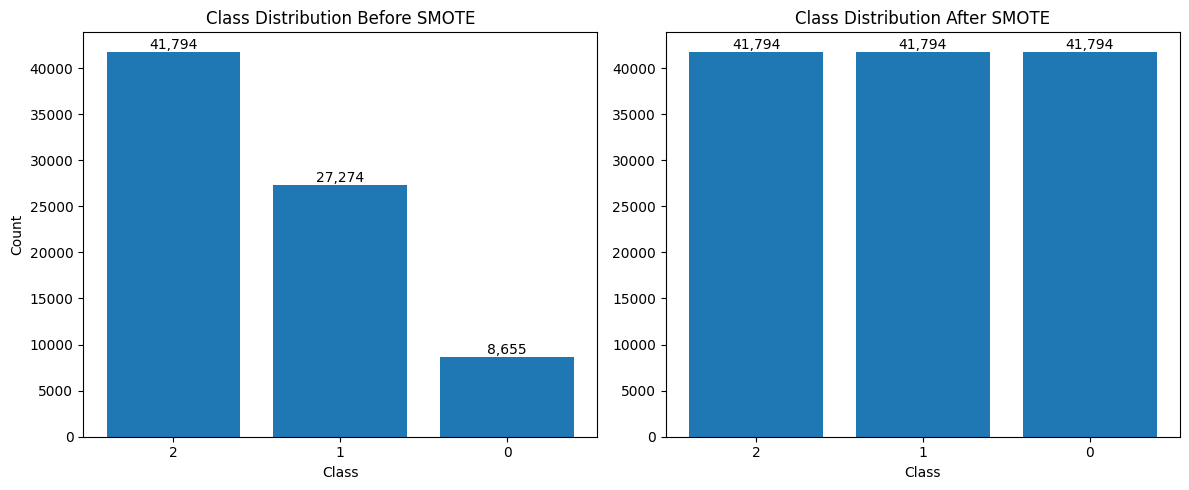

In [22]:
# getting label and value
before_counts = y_train.value_counts() 
after_counts = ytrain_smote.value_counts()  

# Helper function to add values on top of bars
def add_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:,}',               # number with commas
                    (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=10)

# 5. Plot BEFORE vs AFTER SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Before SMOTE ---
ax1 = axes[0]
ax1.bar(before_counts.index.astype(str), before_counts.values)
ax1.set_title("Class Distribution Before SMOTE")
ax1.set_xlabel("Class")
ax1.set_ylabel("Count")
add_labels(ax1)

# --- After SMOTE ---
ax2 = axes[1]
ax2.bar(after_counts.index.astype(str), after_counts.values)
ax2.set_title("Class Distribution After SMOTE")
ax2.set_xlabel("Class")
add_labels(ax2)

plt.tight_layout()
plt.show();

## fitting models

### 1. Logistic regression (simple baseline)

In [23]:
# import needed libraries
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [24]:
# Scale Data for Logistic Regression + MLP
scaler = StandardScaler()

# Fit scaler on SMOTE training data only
X_train_scaled = scaler.fit_transform(xtrain_smote)
X_test_scaled = scaler.transform(X_test)


In [25]:
# fitting logistic regression
log_reg = LogisticRegression(max_iter=500, class_weight='balanced')

log_reg.fit(X_train_scaled, ytrain_smote)

y_pred_lr = log_reg.predict(X_test_scaled)

print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.16      0.27      0.20      2152
           1       0.45      0.29      0.35      6864
           2       0.61      0.67      0.64     10458

    accuracy                           0.49     19474
   macro avg       0.41      0.41      0.40     19474
weighted avg       0.51      0.49      0.49     19474



### 2. Random Forest


In [26]:
rf = RandomForestClassifier() # initialization.

rf_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV( # look for best hyperparameters
    estimator=rf,
    param_grid=rf_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(xtrain_smote, ytrain_smote)

print("Best RF Params:", rf_grid.best_params_)

rf_best = rf_grid.best_estimator_

y_pred_rf = rf_best.predict(X_test)

print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}

=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.22      0.07      0.10      2152
           1       0.49      0.42      0.45      6864
           2       0.62      0.77      0.69     10458

    accuracy                           0.57     19474
   macro avg       0.44      0.42      0.42     19474
weighted avg       0.53      0.57      0.54     19474



### 3. MLP neural network

In [27]:
mlp = MLPClassifier(max_iter=300)

mlp_param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64,32)],
    'activation': ['relu'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]
}

mlp_grid = GridSearchCV(
    estimator=mlp,
    param_grid=mlp_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

mlp_grid.fit(X_train_scaled, ytrain_smote)

print("Best MLP Params:", mlp_grid.best_params_)

mlp_best = mlp_grid.best_estimator_

y_pred_mlp = mlp_best.predict(X_test_scaled)

print("\n=== MLP Classifier Report ===")
print(classification_report(y_test, y_pred_mlp))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}

=== MLP Classifier Report ===
              precision    recall  f1-score   support

           0       0.24      0.10      0.14      2152
           1       0.46      0.40      0.43      6864
           2       0.62      0.74      0.68     10458

    accuracy                           0.55     19474
   macro avg       0.44      0.41      0.41     19474
weighted avg       0.52      0.55      0.53     19474



### 4. Xgboost

In [28]:
from xgboost import XGBClassifier

In [29]:
# ============================
# XGBOOST CLASSIFIER + GRID SEARCH
# ============================

# Scale the data first (use your existing scaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(xtrain_smote)
X_test_scaled = scaler.transform(X_test)

# XGBoost parameter grid
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05],
    "n_estimators": [200, 400],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 1]
}

xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_scaled, ytrain_smote)

print("Best XGBoost Params:")
print(xgb_grid.best_params_)

print("\nBest XGBoost Score (CV F1 Macro):")
print(xgb_grid.best_score_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best XGBoost Params:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'subsample': 0.8}

Best XGBoost Score (CV F1 Macro):
0.47484995967422394


In [30]:
# Evaluate XGBoost on test set
xgb_best = xgb_grid.best_estimator_

y_pred_xgb = xgb_best.predict(X_test_scaled)
y_proba_xgb = xgb_best.predict_proba(X_test_scaled)

# Metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb, average="macro")
xgb_recall = recall_score(y_test, y_pred_xgb, average="macro")
xgb_f1 = f1_score(y_test, y_pred_xgb, average="macro")
xgb_auc = roc_auc_score(y_test, y_proba_xgb, multi_class="ovr")

print("XGBoost Test Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision (Macro): {xgb_precision:.4f}")
print(f"Recall (Macro): {xgb_recall:.4f}")
print(f"F1 (Macro): {xgb_f1:.4f}")
print(f"AUC (Macro): {xgb_auc:.4f}")


XGBoost Test Performance:
Accuracy: 0.5738
Precision (Macro): 0.4676
Recall (Macro): 0.4337
F1 (Macro): 0.4350
AUC (Macro): 0.6606


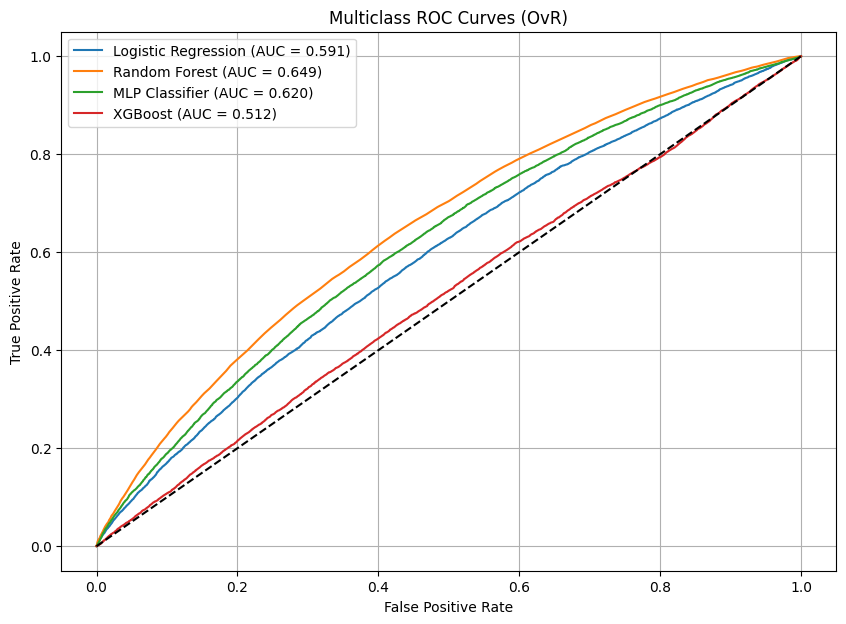

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the test labels for multiclass ROC
classes = sorted(ytrain_smote.unique())
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# Get probability predictions
lr_probs  = log_reg.predict_proba(X_test_scaled)
rf_probs  = rf_best.predict_proba(X_test)
mlp_probs = mlp_best.predict_proba(X_test_scaled)
xgb_probs = xgb_best.predict_proba(X_test)     

model_probs = {
    "Logistic Regression": lr_probs,
    "Random Forest": rf_probs,
    "MLP Classifier": mlp_probs,
    "XGBoost": xgb_probs                        
}

plt.figure(figsize=(10, 7))

for model_name, probs in model_probs.items():
    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{model_name} (AUC = {macro_auc:.3f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # chance diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (OvR)")
plt.legend()
plt.grid(True)
plt.show()


### Model Comparison table

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Helper: multiclass AUC
def multiclass_auc(model, X_test, y_test):
    try:
        probs = model.predict_proba(X_test)
        return roc_auc_score(y_test, probs, multi_class='ovr')
    except:
        return None

results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision Macro": precision_score(y_test, y_pred_lr, average="macro"),
    "Recall Macro": recall_score(y_test, y_pred_lr, average="macro"),
    "F1 Macro": f1_score(y_test, y_pred_lr, average="macro"),
    "AUC Macro": multiclass_auc(log_reg, X_test_scaled, y_test),
    "Best Params": "N/A"
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision Macro": precision_score(y_test, y_pred_rf, average="macro"),
    "Recall Macro": recall_score(y_test, y_pred_rf, average="macro"),
    "F1 Macro": f1_score(y_test, y_pred_rf, average="macro"),
    "AUC Macro": multiclass_auc(rf_best, X_test, y_test),
    "Best Params": rf_grid.best_params_
})

# MLP Classifier
results.append({
    "Model": "MLP Classifier",
    "Accuracy": accuracy_score(y_test, y_pred_mlp),
    "Precision Macro": precision_score(y_test, y_pred_mlp, average="macro"),
    "Recall Macro": recall_score(y_test, y_pred_mlp, average="macro"),
    "F1 Macro": f1_score(y_test, y_pred_mlp, average="macro"),
    "AUC Macro": multiclass_auc(mlp_best, X_test_scaled, y_test),
    "Best Params": mlp_grid.best_params_
})

# XG boost
results.append({
    "Model": "XGB Classifier",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision Macro": precision_score(y_test, y_pred_xgb, average="macro"),
    "Recall Macro": recall_score(y_test, y_pred_xgb, average="macro"),
    "F1 Macro": f1_score(y_test, y_pred_xgb, average="macro"),
    "AUC Macro": multiclass_auc(xgb_best, X_test_scaled, y_test),
    "Best Params": xgb_grid.best_params_
})


comparison_df = pd.DataFrame(results)
comparison_df


,Model,Accuracy,Precision Macro,Recall Macro,F1 Macro,AUC Macro,Best Params
0,Logistic Regression,0.491938,0.408377,0.409394,0.397107,0.590863,N/A
1,Random Forest,0.568245,0.444377,0.419362,0.415099,0.648764,"{'class_weight': 'balanced', 'max_depth': None..."
2,MLP Classifier,0.552275,0.439324,0.414773,0.414421,0.619938,"{'activation': 'relu', 'alpha': 0.001, 'hidden..."
3,XGB Classifier,0.573791,0.467590,0.433720,0.434999,0.660554,"{'colsample_bytree': 1.0, 'gamma': 0, 'learnin..."


#### Model Performance Interpretation

The predictive performance of the four models—Logistic Regression, Random Forest, Multilayer Perceptron (MLP), and XGBoost—provides important insight into the challenges associated with forecasting hospital readmissions in this dataset. Overall, all models demonstrated moderate performance, reflecting the inherent complexity and imbalance of readmission prediction as a clinical task.

Logistic Regression produced the lowest performance across all metrics, with a macro F1-score of 0.397 and an AUC of 0.591. This suggests that linear decision boundaries may be insufficient to capture the underlying patterns in the dataset. The Multilayer Perceptron showed modest improvement, achieving a macro AUC of 0.620, indicating that nonlinear relationships exist but remain difficult to fully exploit even with neural network architectures.

Tree-based ensemble models performed comparatively better. The Random Forest classifier achieved an AUC of 0.649, reflecting stronger discriminatory ability, likely due to its robustness to noisy or nonlinear features. XGBoost achieved the highest performance overall, with a macro AUC of 0.661, the highest precision and recall among all models, and the strongest macro F1-score (0.435). These results indicate that gradient boosting techniques are more capable of leveraging complex interactions between clinical features and readmission outcomes.

Despite XGBoost being the best-performing model, the absolute values of accuracy, recall, and AUC across all models remain moderate. This suggests that the dataset may have limitations—such as class imbalance, feature sparsity, or limited clinical granularity—that make prediction inherently challenging. These findings reinforce the importance of incorporating explainability (XAI), better feature engineering, and potentially additional contextual or temporal features to enhance model performance in future iterations.

# XAI
Section to try and find out the underpinnings of the predictions.

In [ ]:
# uncomment and run this to install SHAP.

#pip install shap  

In [86]:
# using the best model.
import shap
import numpy as np

# Use the training set (X_test is fine for displaying global explanations)
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)


### summary plot (feature importance + directionality)

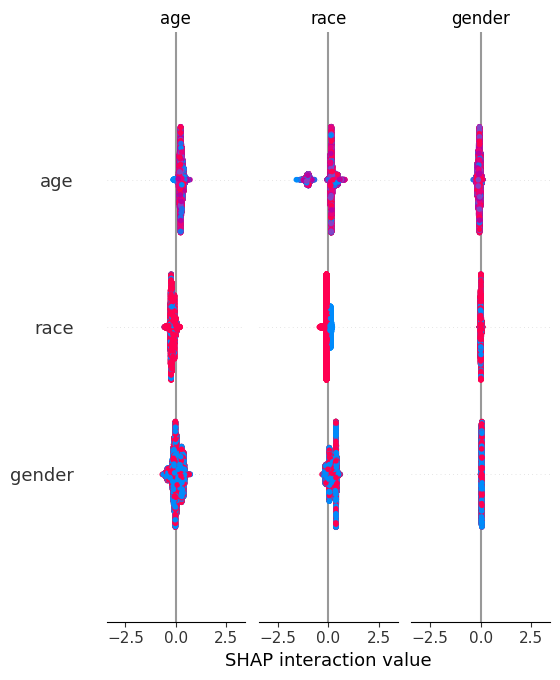

In [87]:
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)


- Features at top are the most influential for readmission risk. (gender, race, age)
- Color = feature value (red = high, blue = low)
- X-axis = impact on prediction

Bar plot of global feature importance

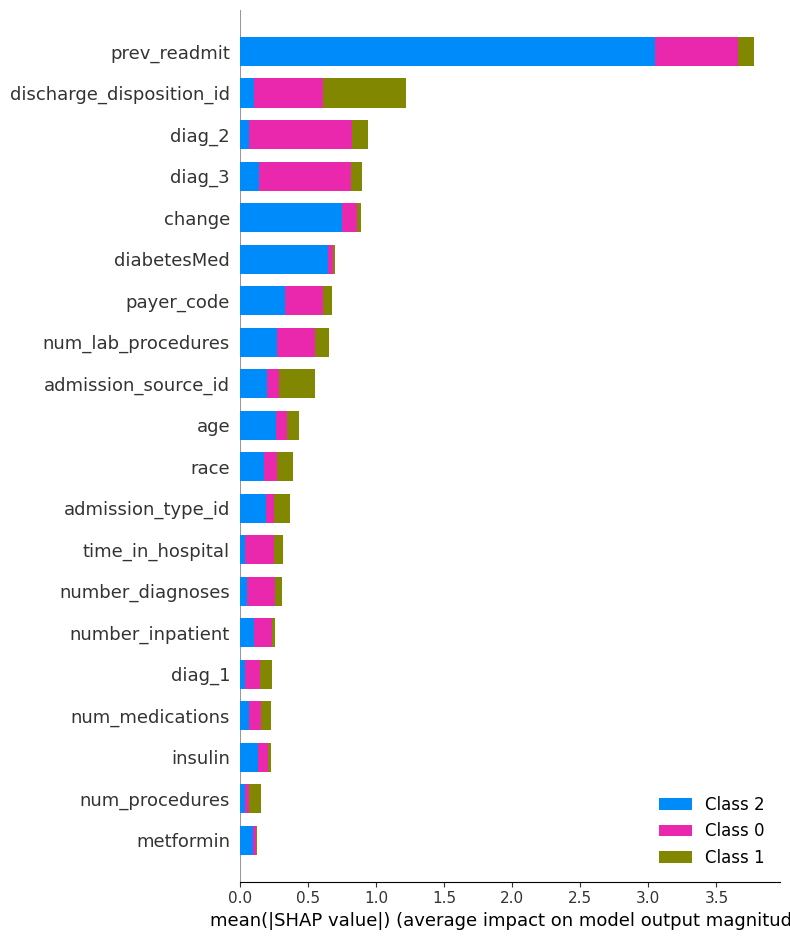

In [88]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)


- Gives a ranked list of global feature influence.

Example using patient on index 10.
- Try to find out for this patient, what features heavily influenced the models, decision.

In [89]:
class_id = 1       # class to explain
sample_idx = 10    # row to explain

# Extract the row's features
row = X_test.iloc[sample_idx]

# Extract shap values for this class (row's shap vector)
shap_row = shap_values[class_id][sample_idx]


In [90]:
exp = shap.Explanation(
    values = shap_row,
    base_values = explainer.expected_value[class_id],
    data = row.values,
    feature_names = X_test.columns
)


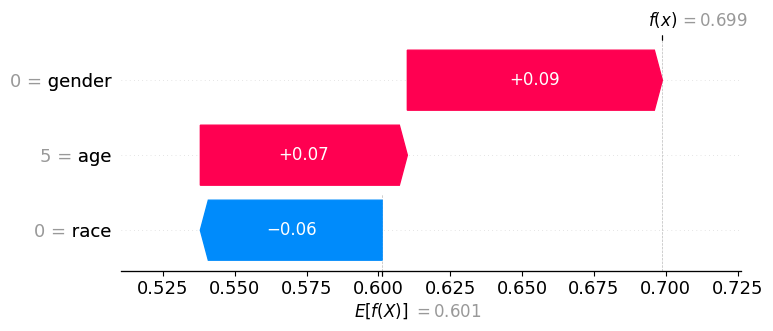

In [91]:
shap.plots.waterfall(exp)


Waterfall Plot Interpretation

The SHAP waterfall plot illustrates how individual feature values contribute to the model’s predicted probability of readmission for a specific patient. The plot begins with the model’s baseline prediction, which represents the average predicted probability across all patients in the dataset. Each feature then pushes this baseline upward or downward depending on whether the feature value increases or decreases the likelihood of readmission.

In the displayed example, gender, age, and race are the primary contributors. The patient’s gender increases the predicted risk, shown by a positive SHAP value that pushes the final prediction higher. Age also contributes positively, indicating that the patient’s age category is associated with an elevated readmission probability relative to the population baseline. Conversely, race contributes negatively, meaning the patient’s specific race category decreases the predicted probability compared to the average case in the dataset. The magnitude of the bars reflects the strength of each feature’s influence, with longer bars indicating stronger contributions. The final predicted probability is obtained after adding all positive and negative feature effects to the baseline, resulting in the model’s individualized risk estimate for this patient.

### Conclusion

This project set out to develop a machine learning pipeline capable of predicting hospital readmissions using a structured clinical dataset. Through extensive preprocessing, patient-level splitting to prevent leakage, feature engineering, SMOTE balancing, and evaluation of multiple models, we achieved moderate predictive performance across all algorithms. Among the models tested, <b>XGBoost</b> consistently performed the best, achieving the highest macro AUC and F1-score. However, even the top-performing model demonstrated only moderate discriminatory power, indicating that the available features do not capture enough of the true complexity behind readmission risk.

Given these performance limitations, implementing a full user interface (UI) at this stage would not be practical or responsible. A UI implies readiness for operational deployment, yet the model is not accurate enough to support clinical or administrative decision-making. Deploying a weak model behind a user-friendly interface could create a false sense of confidence, leading to potential misinterpretations or inappropriate actions. For this reason, the project instead shifted towards explainable AI (XAI) methods such as SHAP to explore and understand why the models behave as they do and to identify which features contribute meaningfully to predictions.

Overall, the project demonstrates that while predictive modeling is feasible, significant improvements to data quality, feature richness, and model interpretability are required before operationalizing the system.

### Next steps

1. Deepen Explainability (XAI):
Expand SHAP analyses to include dependence plots, summary plots, and feature-level insights. This will help identify which features are truly meaningful and which require refinement or removal.

2. Improve Feature Engineering:
- Incorporate richer temporal features (e.g., sequence of encounters, time since last admission).
- Build comorbidity indices (Charlson, Elixhauser).
- Aggregate medication and lab result patterns.
- Explore interaction terms and non-linear transformations.

3. Experiment With Advanced Models:
- Gradient boosting with custom loss functions.
- Recurrent or transformer-based models for sequential data.
- Survival models if time-to-readmission becomes relevant.

4. Re-evaluate Deployment After Model Improvements:
Only if performance metrics reach clinically acceptable levels should a UI or decision-support tool be considered. Until then, development should remain focused on model refinement and explainability.

# References
1. GroupShuffleSplit. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html
2. GeeksforGeeks. (2025, November 13). SMOTE for Imbalanced Classification with Python. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/smote-for-imbalanced-classification-with-python